In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
dataset = pd.read_csv('/content/openb_pod_list_cpu0.csv')

In [5]:
# Step 1: Data Preprocessing
dataset = dataset.drop(columns=['gpu_spec'], errors='ignore')  # Drop unnecessary columns
dataset['scheduled_time'] = dataset['scheduled_time'].fillna(dataset['scheduled_time'].median())  # Fill NaN

In [6]:
# Convert time columns to hours
dataset['creation_time_hr'] = dataset['creation_time'] / 3600
dataset['deletion_time_hr'] = dataset['deletion_time'] / 3600
dataset['scheduled_time_hr'] = dataset['scheduled_time'] / 3600


In [7]:
# Standardize selected features for clustering
features = ['cpu_milli', 'memory_mib', 'gpu_milli', 'creation_time_hr', 'scheduled_time_hr']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset[features])

<ipython-input-8-8a4e31530283>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='qos', y='cpu_milli', data=dataset, palette="Blues")


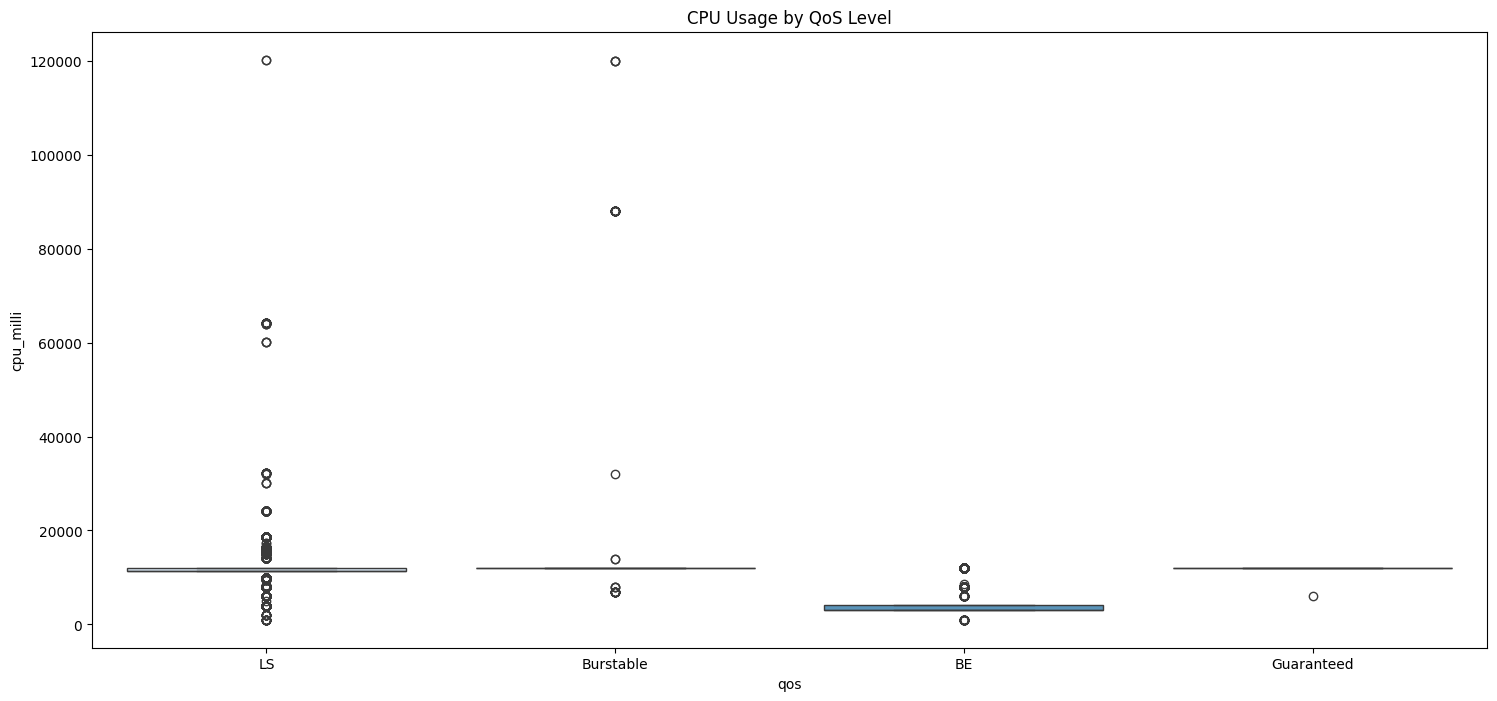

In [8]:
# Step 2: Extended EDA with Visualizations
# Resource usage by QoS
plt.figure(figsize=(18, 8))
sns.boxplot(x='qos', y='cpu_milli', data=dataset, palette="Blues")
plt.title("CPU Usage by QoS Level")
plt.show()

<ipython-input-9-70cf8911206c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pod_phase', y='cpu_milli', data=dataset, palette="Purples")


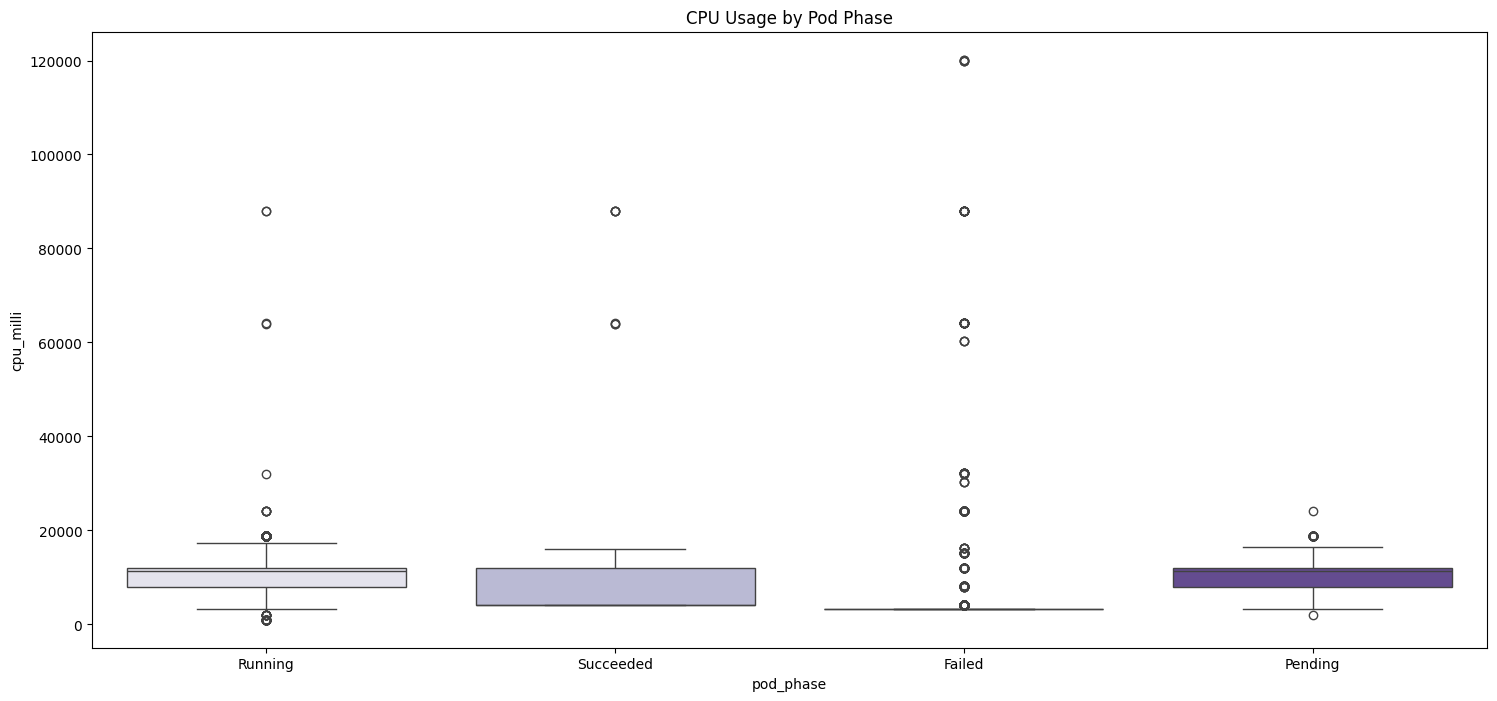

In [9]:
# CPU and Memory usage by Pod Phase
plt.figure(figsize=(18, 8))
sns.boxplot(x='pod_phase', y='cpu_milli', data=dataset, palette="Purples")
plt.title("CPU Usage by Pod Phase")
plt.show()

In [10]:
# Step 3: Clustering - Determine Optimal Number of Clusters (Elbow Method)
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

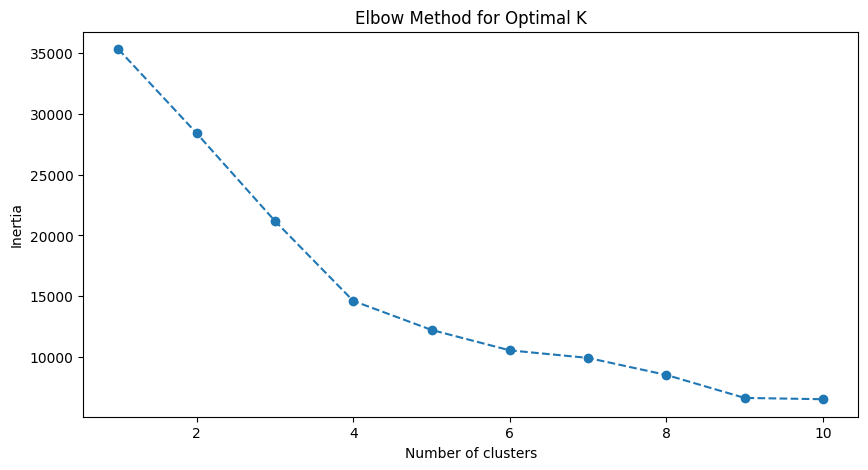

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [12]:
# Apply KMeans with optimal clusters (assume optimal is 3)
kmeans = KMeans(n_clusters=3, random_state=0)
dataset['cluster'] = kmeans.fit_predict(X_scaled)


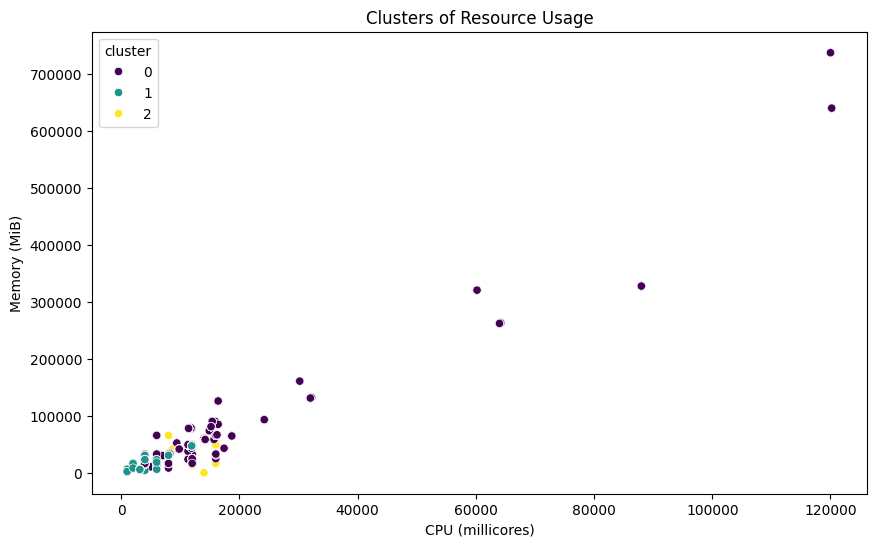

In [13]:
# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dataset, x='cpu_milli', y='memory_mib', hue='cluster', palette='viridis')
plt.title("Clusters of Resource Usage")
plt.xlabel("CPU (millicores)")
plt.ylabel("Memory (MiB)")
plt.show()

In [14]:
# Step 4: Classification - Predict QoS Levels
# Prepare data for classification
X = dataset[['cpu_milli', 'memory_mib', 'gpu_milli', 'creation_time_hr', 'scheduled_time_hr']]
y = dataset['qos']

In [15]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [16]:
# Train a Random Forest Classifier
classifier = RandomForestClassifier(random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [17]:
# Predict and evaluate
y_pred = classifier.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          BE       1.00      1.00      1.00       877
   Burstable       0.39      0.33      0.36        21
  Guaranteed       0.00      0.00      0.00         2
          LS       0.99      0.99      0.99      1220

    accuracy                           0.99      2120
   macro avg       0.59      0.58      0.59      2120
weighted avg       0.99      0.99      0.99      2120

Confusion Matrix:
[[ 876    0    0    1]
 [   2    7    1   11]
 [   0    1    0    1]
 [   0   10    1 1209]]


In [18]:
# Step 5: NLP Processing (if text data is available)
# Assume a 'description' field exists with pod descriptions or logs
if 'description' in dataset.columns:
    vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
    tfidf_matrix = vectorizer.fit_transform(dataset['description'].fillna(''))

    # Convert TF-IDF matrix to DataFrame and merge with dataset
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    dataset = pd.concat([dataset.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

In [19]:
# Final Dataset View
print(dataset.head())

             name  cpu_milli  memory_mib  num_gpu  gpu_milli qos pod_phase  \
0  openb-pod-0000      12000       16384        1       1000  LS   Running   
1  openb-pod-0001       6000       12288        1        460  LS   Running   
2  openb-pod-0002      12000       24576        1       1000  LS   Running   
3  openb-pod-0003       6000       12288        1        460  LS   Running   
4  openb-pod-0004      12000       16384        1       1000  LS   Running   

   creation_time  deletion_time  scheduled_time  creation_time_hr  \
0              0       12537496             0.0          0.000000   
1         427061       12902960        427061.0        118.628056   
2        1558381       12902960       1558381.0        432.883611   
3        2690044       12902960       2690044.0        747.234444   
4        2758084       12902960       2758084.0        766.134444   

   deletion_time_hr  scheduled_time_hr  cluster  
0       3482.637778           0.000000        2  
1       3584.155

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA


In [23]:
import pandas as pd

# Load your dataset; replace 'path_to_your_dataset.csv' with the actual path to your CSV file.
try:
    data = pd.read_csv('/content/openb_pod_list_cpu0.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: The file path is incorrect. Please check the file path and try again.")
except Exception as e:
    print(f"An error occurred: {e}")

# Convert 'timestamp' to datetime if the dataset loaded correctly
if 'timestamp' in data.columns:
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data.set_index('timestamp', inplace=True)
else:
    print("Error: 'timestamp' column not found in the dataset.")

# Display the first few rows of the data to confirm it loaded properly
print(data.head())


Dataset loaded successfully!
Error: 'timestamp' column not found in the dataset.
             name  cpu_milli  memory_mib  num_gpu  gpu_milli  gpu_spec qos  \
0  openb-pod-0000      12000       16384        1       1000       NaN  LS   
1  openb-pod-0001       6000       12288        1        460       NaN  LS   
2  openb-pod-0002      12000       24576        1       1000       NaN  LS   
3  openb-pod-0003       6000       12288        1        460       NaN  LS   
4  openb-pod-0004      12000       16384        1       1000       NaN  LS   

  pod_phase  creation_time  deletion_time  scheduled_time  
0   Running              0       12537496             0.0  
1   Running         427061       12902960        427061.0  
2   Running        1558381       12902960       1558381.0  
3   Running        2690044       12902960       2690044.0  
4   Running        2758084       12902960       2758084.0  


In [24]:
# Select features and target variable
# Replace 'pod_phase' and 'cpu_milli' with actual column names in your dataset
X = data[['pod_phase']]  # Add any other features here
y = data['cpu_milli']    # Use the appropriate target column

In [25]:
# One-hot encode categorical columns if necessary
X = pd.get_dummies(X)


In [26]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Initialize and train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [28]:
# Make predictions
y_pred = rf_model.predict(X_test)

In [29]:
# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 53688623.199289605
R-squared Score: 0.04862289112369078


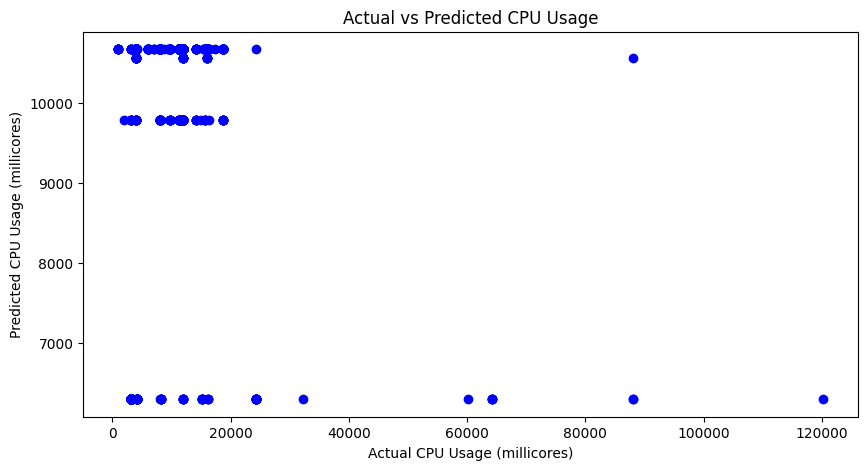

In [30]:
# Plot Actual vs. Predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, color='blue')
plt.xlabel("Actual CPU Usage (millicores)")
plt.ylabel("Predicted CPU Usage (millicores)")
plt.title("Actual vs Predicted CPU Usage")
plt.show()